<a href="https://colab.research.google.com/github/yces990069/invoice-detect/blob/main/invoice_detection_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#將CV2更新至最新版

In [ ]:
!pip install --upgrade opencv-python

     |████████████████████████████████| 49.9 MB 16 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


#連接雲端硬碟

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


#放入圖片路徑

In [ ]:
path="/content/gdrive/MyDrive/train data/IMG_20210829_074634.jpg"#put the picture path on it <---------------------------

#定位並輸出框選範圍

380 436 190 36


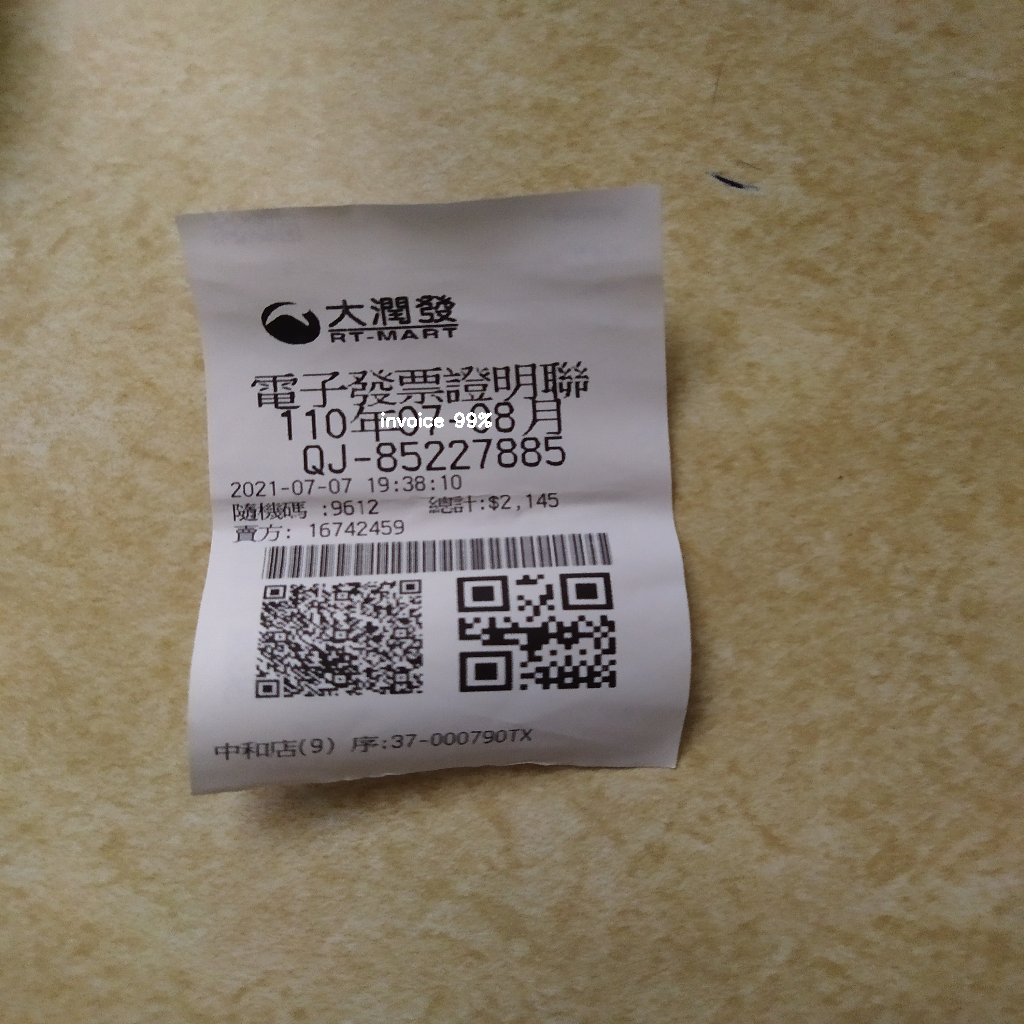

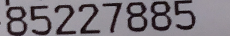

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
classfile = "/content/gdrive/MyDrive/pythonai/classes.names"#put the file"classes.names" path on it <---------------------------
classnames = []
with open(classfile,"rt") as f:
    classnames =  f.read().rstrip("\n").split("\n")
model_cfg ="/content/gdrive/MyDrive/pythonai/obj.cfg"#put the file"obj.cfg" path on it <---------------------------
model_weights ="/content/gdrive/MyDrive/pythonai/obj_final.weights"#put the file"obj_final.weights" path on it <---------------------------
net=cv2.dnn.readNetFromDarknet(model_cfg,model_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
input_width = 416
input_height = 416
confThreshold = 0.5
nmsThreshold = 0.3
def findObjects(outputs, img):
    global crop_img
    H, W, C = img.shape
    bbox = []
    classids = []
    confs = []
    for output in outputs:
        for array in output:
            scores = array[5:]
            classid = np.argmax(scores)
            confidence = scores[classid]
            if(confidence > confThreshold):
                w, h = int(array[2] * W), int(array[3] * H)
                x, y = int((array[0] * W) - w/2), int((array[1] * H) - h/2)
                bbox.append([x,y,w,h])
                classids.append(classid)
                confs.append(float(confidence))
    indices = cv2.dnn.NMSBoxes(bbox, confs, confThreshold, nmsThreshold)
    for i in indices:
        box = bbox[i[0]]
        x, y, w, h = box[0], box[1], box[2], box[3]
        print(x, y, w, h)
        biasx=10
        biasw=30
        crop_img=img[y:y+h, x-biasx:x+w+biasw]
        #cv2.rectangle(img, (x,y), (x+w,y+h), (200,0,0), 2)
        cv2.putText(img,"{} {}%".format(classnames[classids[i[0]]],int(confs[i[0]]*100)),(x, y-10), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
img=cv2.imread(path)
img = cv2.resize(img, (1024,1024))
blob = cv2.dnn.blobFromImage(img, 1/255, (input_width, input_height), [0,0,0], 1, crop = False)
net.setInput(blob)
layernames = net.getLayerNames()
outputnames = [layernames[i[0] - 1] for i in net.getUnconnectedOutLayers()]
outputs = net.forward(outputnames)
findObjects(outputs, img)
cv2_imshow(img)
cv2_imshow(crop_img)
cv2.waitKey(0)

In [ ]:
img=crop_img
img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 轉換了灰度化
ret,img_thre = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)
white = []
black = []
height=img_thre.shape[0]
width=img_thre.shape[1]
white_max = 0
black_max = 0
for i in range(width):
    s = 0
    t = 0
    for j in range(height):
        if img_thre[j][i] == 255:
            s += 1
        if img_thre[j][i] == 0:
            t += 1
    white_max = max(white_max, s)
    black_max = max(black_max, t)
    white.append(s)
    black.append(t)
arg = False 
if black_max > white_max:
    arg = True
def find_end(start_):
  end_ = start_ + 1
  for m in range(start_ + 1, width -1):
    if (black[m] if arg else white[m]) > (0.95 * black_max if arg else 0.95 * white_max):
      end_ = m
      break
  return end_
n=1
start=1
end=2
word=[]
while n < width - 1:
    n += 1
    if (white[n] if arg else black[n]) > (0.05 * white_max if arg else 0.05 * black_max):
        start = n
        end = find_end(start)
        n = end
        if end - start > 5:
            cj = img[1:height, start:end]
            cj = cv2.resize(cj, (15, 30))
            word.append(cj)
if  len(word)>8:
    word=word[1:9]

#一次輸出被切割之字元

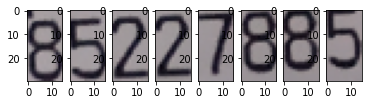

-1

In [ ]:
for i,j in enumerate(word):
    plt.subplot(1,len(word),i+1)
    plt.imshow(word[i],cmap='gray')
plt.show()
cv2.waitKey(0)

#導入訓練好的模型並預測

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ColabNotebooks/model')#put the file"model" path on it <---------------------------
for i in range(len(word)):
    img=word[i]
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(28,28))
    img=np.reshape(img,(1,28,28,1))
    predict_x=new_model.predict(img) 
    p=np.argmax(predict_x,axis=1)
    print(p)

[8]
[5]
[2]
[2]
[7]
[8]
[8]
[5]
